In [2]:
%matplotlib widget
import pickle
from generate_chunks import load_data
from failure_detection import detect_failures, failure_list_to_interval, print_failures, collate_intervals, extreme_anomaly, simple_lowpass_filter
import matplotlib.pyplot as plt
import numpy as np
from extract_rules import construct_features

train_chunks, training_chunk_dates, test_chunks, test_chunk_dates = load_data(version=3)
with open('data/pt3_train_chunks_unnormalized.pkl', 'rb') as f:
    train_chunks_unnormalized = pickle.load(f)
with open('data/pt3_test_chunks_unnormalized.pkl', 'rb') as f:
    test_chunks_unnormalized = pickle.load(f)

train_chunks_features = construct_features(train_chunks_unnormalized, axis=1).swapaxes(1,2)
#train_chunks_features = train_chunks_features[..., [2, 3]]
test_chunks_features = construct_features(test_chunks_unnormalized, axis=1).swapaxes(1,2)
#test_chunks_features = test_chunks_features[..., [2, 3]]
print(train_chunks_features.shape)

(72226, 13, 4)


if_default (array([0, 1]), array([28081,  6952]))
if_contamination (array([0, 1]), array([32327,  2706]))
if_manual (array([0, 1], dtype=int8), array([31717,  3316]))


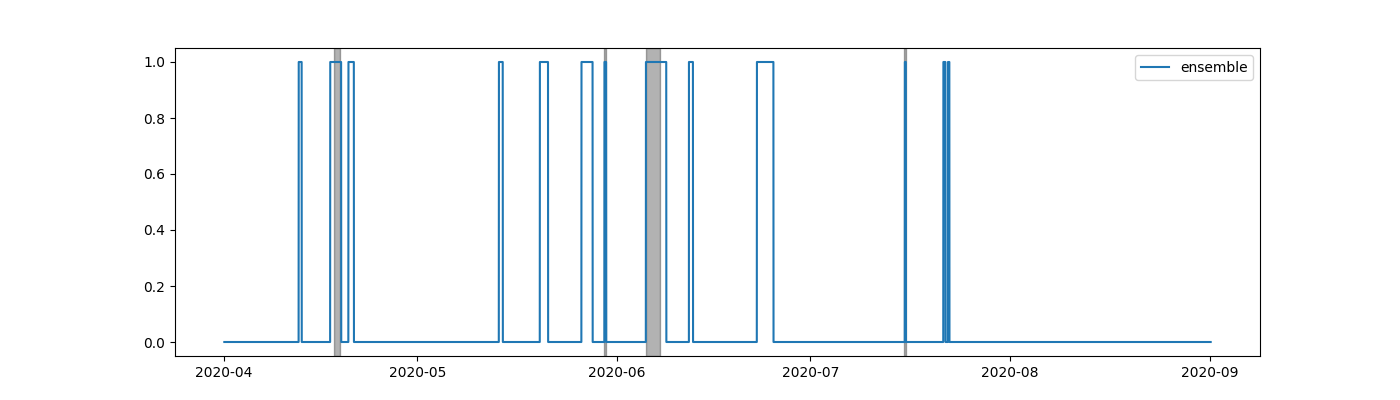

In [3]:
from sklearn.ensemble import IsolationForest

bs_train = train_chunks_features.shape[0]
bs_test = test_chunks_features.shape[0]

# default parameters
IF = IsolationForest(random_state=937171)
IF.fit(train_chunks_features.reshape(bs_train, -1))
if_default_preds = ((IF.predict(test_chunks_features.reshape(bs_test, -1)))*-1 + 1) // 2
print('if_default', np.unique(if_default_preds, return_counts=True))

# Contamination
IF = IsolationForest(contamination=0.01, random_state=937171)
IF.fit(train_chunks_features.reshape(bs_train, -1))
if_contamination_preds = ((IF.predict(test_chunks_features.reshape(bs_test, -1)))*-1 + 1) // 2
print('if_contamination', np.unique(if_contamination_preds, return_counts=True))

# Manual
IF = IsolationForest(random_state=937171)
IF.fit(train_chunks_features.reshape(bs_train, -1))
train_scores = -1*IF.score_samples(train_chunks_features.reshape(bs_train, -1))
anom = extreme_anomaly(train_scores)
if_manual_preds = ((-1*IF.score_samples(test_chunks_features.reshape(bs_test, -1))) > anom).astype(np.int8)
print('if_manual', np.unique(if_manual_preds, return_counts=True))

# OneClassSVM
# from sklearn.svm import OneClassSVM
# svm = OneClassSVM()
# svm.fit(train_chunks_features.reshape(bs_train, -1))
# train_scores = -1*svm.score_samples(train_chunks_features.reshape(bs_train, -1))
# anom = extreme_anomaly(train_scores)
# svm_default_preds = ((-1*svm.score_samples(test_chunks_features.reshape(bs_test, -1))) > anom).astype(np.int8)
# print('svm_default', np.unique(svm_default_preds, return_counts=True))

# Visualize
alpha = 0.05
default_output = (simple_lowpass_filter(if_default_preds, alpha) >= 0.5).astype(np.int8)
contamination_output = (simple_lowpass_filter(if_contamination_preds, alpha) >= 0.5).astype(np.int8)
manual_output = (simple_lowpass_filter(if_manual_preds, alpha) >= 0.5).astype(np.int8)

plt.figure(figsize=(14, 4))

actual_failures = [
    (np.datetime64('2020-04-18T00:00:00'), np.datetime64('2020-04-18T23:59:00')),
    (np.datetime64('2020-05-29T23:30:00'), np.datetime64('2020-05-30T06:00:00')),
    (np.datetime64('2020-06-05T10:00:00'), np.datetime64('2020-06-07T14:30:00')),
    (np.datetime64('2020-07-15T14:30:00'), np.datetime64('2020-07-15T19:00:00')),
]
for (start, end) in actual_failures:
    plt.axvspan(start, end, color='black', alpha=0.3)

from scipy.stats import mode
# plt.plot(test_chunk_dates[:, 1], default_output, label='IF-default')
# plt.plot(test_chunk_dates[:, 1], contamination_output, label='IF-contamination=0.01')
# plt.plot(test_chunk_dates[:, 1], manual_output, label='IF-manual')
plt.plot(test_chunk_dates[:, 1], mode(np.vstack([default_output, contamination_output, manual_output]), axis=0).mode, label='ensemble')
plt.legend()
plt.show()



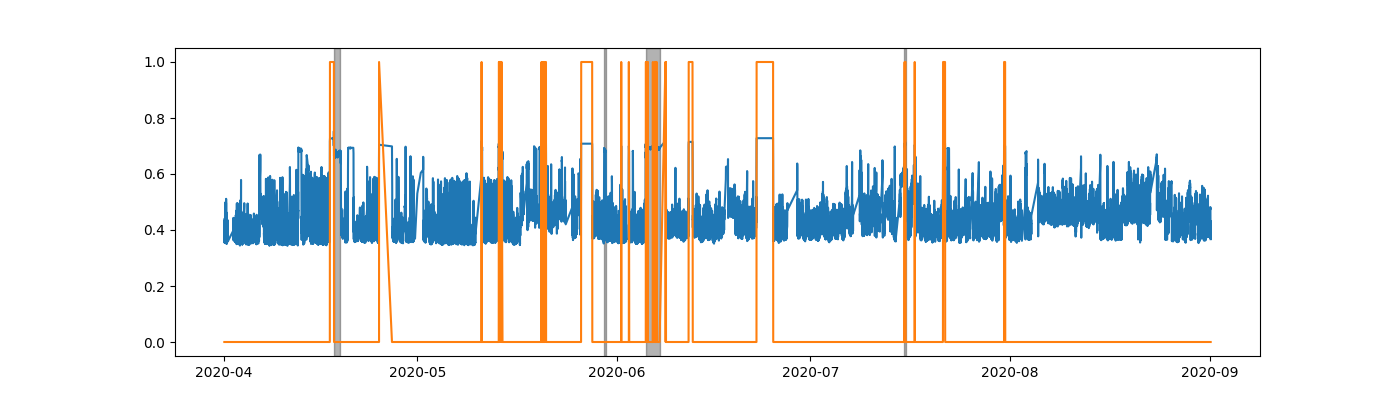

In [10]:
IF = IsolationForest(random_state=937171)
IF.fit(train_chunks_features.reshape(bs_train, -1))
if_manual_preds = -1*IF.score_samples(test_chunks_features.reshape(bs_test, -1))

plt.figure(figsize=(14, 4))
for (start, end) in actual_failures:
    plt.axvspan(start, end, color='black', alpha=0.3)
plt.plot(test_chunk_dates[:, 1], if_manual_preds)
plt.plot(test_chunk_dates[:, 1], if_manual_preds>=0.7)
plt.show()